Data retrieved from SN91080!
Data retrieved from SN90450!
                       elementId  value unit timeOffset timeResolution  \
0  sum(precipitation_amount P1D)   14.7   mm       PT6H            P1D   
1  sum(precipitation_amount P1D)   18.6   mm       PT6H            P1D   
2  sum(precipitation_amount P1D)    6.5   mm       PT6H            P1D   
3  sum(precipitation_amount P1D)    4.7   mm       PT6H            P1D   
4  sum(precipitation_amount P1D)    8.1   mm       PT6H            P1D   

   timeSeriesId performanceCategory exposureCategory  qualityCode  \
0             0                   C                2            0   
1             0                   C                2            0   
2             0                   C                2            0   
3             0                   C                2            0   
4             0                   C                2            0   

              referenceTime   sourceId  
0  2024-12-26T00:00:00.000Z  SN91080:0  


C:\Users\Marti\AppData\Local\Temp\ipykernel_3808\3369163788.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data2['referenceTime'] = pd.to_datetime(temperature_data2['referenceTime'])
C:\Users\Marti\AppData\Local\Temp\ipykernel_3808\3369163788.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitation_data2['referenceTime'] = pd.to_datetime(precipitation_data2['referenceTime'])
C:\Users\Marti\AppData\Local\Temp\ipykernel_3808\3369163788.py:144: SettingWithCopyWarning: 
A value is 

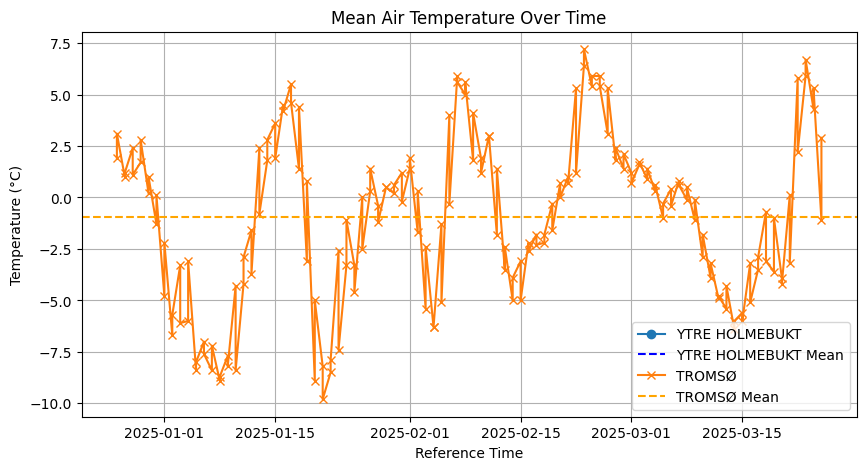

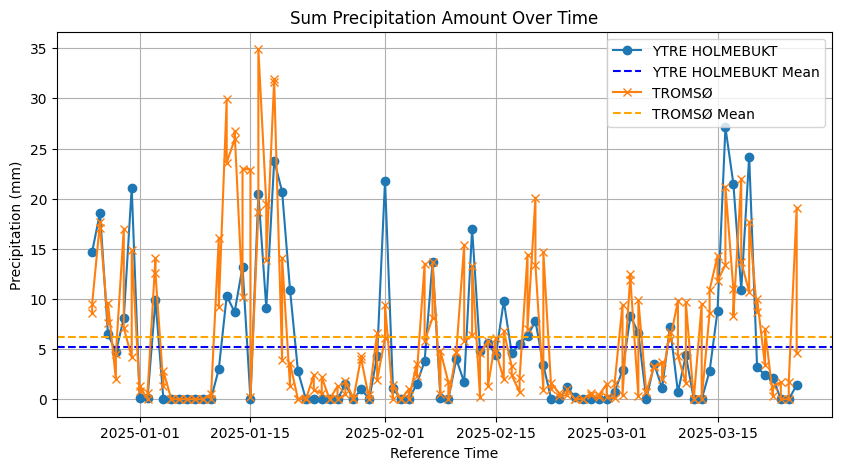

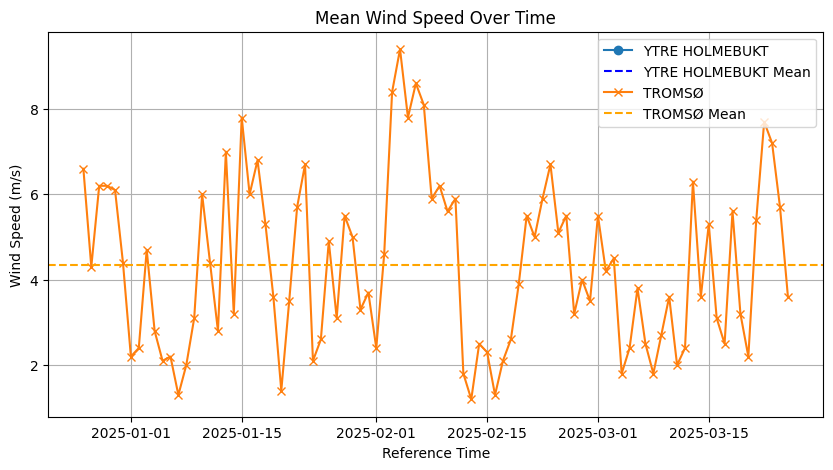

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Definerer geolocator
geolocator = Nominatim(user_agent="weather_app")

# Henter inn to lokasjoner fra brukeren
location_input1 = input("Enter the first location (e.g., Bergen, Oslo, Trondheim, Stavanger, Tromsø): ")
location_input2 = input("Enter the second location (e.g., Bergen, Oslo, Trondheim, Stavanger, Tromsø): ")

# Geokoder lokasjonene for å få koordinatene
location1 = geolocator.geocode(location_input1)
location2 = geolocator.geocode(location_input2)

# Koordinater for lokasjonene
location_coords1 = (location1.latitude, location1.longitude)
location_coords2 = (location2.latitude, location2.longitude)

# Vår klient-id for å hente data fra Frost API
client_id = '2e243d34-57bc-42b4-8095-239991af5353'

# Definerer endepunkt og parametere for stasjoner
stations_endpoint = 'https://frost.met.no/sources/v0.jsonld'
stations_parameters = {
    'types': 'SensorSystem'
}

# Henter ut HTTP responsen og lagrer den som JSON
r = requests.get(stations_endpoint, stations_parameters, auth=(client_id,''))
stations_json = r.json()

# Henter ut stasjonsinformasjonen
stations = stations_json['data']

# Lager et dictionary med stasjons-ID som nøkkel og koordinater som verdi
weather_stations_coords = {station['id']: (station['geometry']['coordinates'][1], station['geometry']['coordinates'][0]) for station in stations if 'geometry' in station}

# Regner ut avstanden til værstasjonene fra den første lokasjonen
distances1 = {station: geodesic(location_coords1, coords).km for station, coords in weather_stations_coords.items()}
# Regner ut avstanden til værstasjonene fra den andre lokasjonen
distances2 = {station: geodesic(location_coords2, coords).km for station, coords in weather_stations_coords.items()}

# Sorterer værstasjonene etter avstand til lokasjonene
sorted_stations1 = sorted(distances1, key=distances1.get)
sorted_stations2 = sorted(distances2, key=distances2.get)

# Henter ut dagens dato og datoen 90 dager tilbake
now = datetime.now()
offset = now - timedelta(days=90)
current_date = now.strftime("%Y-%m-%d")
historic_date = offset.strftime("%Y-%m-%d")

# Definerer endepunkt og parametere for observasjoner
observations_endpoint = 'https://frost.met.no/observations/v0.jsonld'

def fetch_data(stations, max_attempts=5):
    """
    Fetch data from the nearest weather stations.
    Tries up to max_attempts stations and returns the data from the first successful attempt.
    """
    for attempt in range(min(max_attempts, len(stations))):
        parameters = {
            'sources': stations[attempt],
            'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
            'referencetime': f'{historic_date}/{current_date}',
        }
        r = requests.get(observations_endpoint, parameters, auth=(client_id,''))
        json = r.json()

        if r.status_code == 200 and 'data' in json:
            data = json['data']
            if data:
                print(f'Data retrieved from {stations[attempt]}!')
                return data, stations[attempt]
        else:
            print(f'Error retrieving data from {stations[attempt]}. Trying next station...')

    # Hvis ingen data blir funnet, returneres data fra den første stasjonen
    parameters = {
        'sources': stations[0],
        'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
        'referencetime': f'{historic_date}/{current_date}',
    }
    r = requests.get(observations_endpoint, parameters, auth=(client_id,''))
    json = r.json()
    data = json['data']
    print(f'No data found from other stations. Using data from {stations[0]}.')
    return data, stations[0]

# Henter data for begge lokasjonene
data1, used_station_id1 = fetch_data(sorted_stations1)
data2, used_station_id2 = fetch_data(sorted_stations2)

# Kartlegging av sourceId til stasjonsnavn
station_names = {station['id']: station['name'] for station in stations if 'name' in station}

important_keys = ['elementId', 'value', 'unit', 'timeOffset', 'timeResolution', 'qualityCode']

# Samler de viktige dataene i DataFrames
df_list1 = []
df_list2 = []

for item in data1:
    row = pd.DataFrame(item['observations'])
    row['referenceTime'] = item['referenceTime']
    row['sourceId'] = item['sourceId']
    df_list1.append(row)

for item in data2:
    row = pd.DataFrame(item['observations'])
    row['referenceTime'] = item['referenceTime']
    row['sourceId'] = item['sourceId']
    df_list2.append(row)

# Effektivt å koble sammen alle DataFrames samtidig
df1 = pd.concat(df_list1, ignore_index=True)
df2 = pd.concat(df_list2, ignore_index=True)

# Viser DataFrames
print(df1.head())
print(df2.head())

# Plotter dataene
# Separerer dataene etter elementId
temperature_data1 = df1[df1['elementId'] == 'mean(air_temperature P1D)']
precipitation_data1 = df1[df1['elementId'] == 'sum(precipitation_amount P1D)']
wind_speed_data1 = df1[df1['elementId'] == 'mean(wind_speed P1D)']

temperature_data2 = df2[df2['elementId'] == 'mean(air_temperature P1D)']
precipitation_data2 = df2[df2['elementId'] == 'sum(precipitation_amount P1D)']
wind_speed_data2 = df2[df2['elementId'] == 'mean(wind_speed P1D)']

# Konverterer referansetiden til datetime
temperature_data1['referenceTime'] = pd.to_datetime(temperature_data1['referenceTime'])
precipitation_data1['referenceTime'] = pd.to_datetime(precipitation_data1['referenceTime'])
wind_speed_data1['referenceTime'] = pd.to_datetime(wind_speed_data1['referenceTime'])

temperature_data2['referenceTime'] = pd.to_datetime(temperature_data2['referenceTime'])
precipitation_data2['referenceTime'] = pd.to_datetime(precipitation_data2['referenceTime'])
wind_speed_data2['referenceTime'] = pd.to_datetime(wind_speed_data2['referenceTime'])

# Plotter gjennomsnittelig lufttemperatur
plt.figure(figsize=(10, 5))
plt.plot(temperature_data1['referenceTime'], temperature_data1['value'], marker='o', label=station_names.get(used_station_id1, used_station_id1))
plt.axhline(y=temperature_data1['value'].mean(), color='blue', linestyle='--', label=f'{station_names.get(used_station_id1, used_station_id1)} Mean')
plt.plot(temperature_data2['referenceTime'], temperature_data2['value'], marker='x', label=station_names.get(used_station_id2, used_station_id2))
plt.axhline(y=temperature_data2['value'].mean(), color='orange', linestyle='--', label=f'{station_names.get(used_station_id2, used_station_id2)} Mean')
plt.xlabel('Reference Time')
plt.ylabel('Temperature (°C)')
plt.title('Mean Air Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotter sum nedbørsmengde
plt.figure(figsize=(10, 5))
plt.plot(precipitation_data1['referenceTime'], precipitation_data1['value'], marker='o', label=station_names.get(used_station_id1, used_station_id1))
plt.axhline(y=precipitation_data1['value'].mean(), color='blue', linestyle='--', label=f'{station_names.get(used_station_id1, used_station_id1)} Mean')
plt.plot(precipitation_data2['referenceTime'], precipitation_data2['value'], marker='x', label=station_names.get(used_station_id2, used_station_id2))
plt.axhline(y=precipitation_data2['value'].mean(), color='orange', linestyle='--', label=f'{station_names.get(used_station_id2, used_station_id2)} Mean')
plt.xlabel('Reference Time')
plt.ylabel('Precipitation (mm)')
plt.title('Sum Precipitation Amount Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotter gjennomsnittelig vindhastighet
plt.figure(figsize=(10, 5))
plt.plot(wind_speed_data1['referenceTime'], wind_speed_data1['value'], marker='o', label=station_names.get(used_station_id1, used_station_id1))
plt.axhline(y=wind_speed_data1['value'].mean(), color='blue', linestyle='--', label=f'{station_names.get(used_station_id1, used_station_id1)} Mean')
plt.plot(wind_speed_data2['referenceTime'], wind_speed_data2['value'], marker='x', label=station_names.get(used_station_id2, used_station_id2))
plt.axhline(y=wind_speed_data2['value'].mean(), color='orange', linestyle='--', label=f'{station_names.get(used_station_id2, used_station_id2)} Mean')
plt.xlabel('Reference Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Mean Wind Speed Over Time')
plt.legend()
plt.grid(True)
plt.show()

print(df)

In [46]:
from datetime import datetime, timedelta

now = datetime.now()

one_year_ago = now - timedelta(days=365)

# Hent dagens dato
current_date = datetime.now().date()

# Beregn datoen for ett år siden
date_time_1=one_year_ago.strftime("%Y-%m-%d")

date_time=now.strftime("%Y-%m-%d")

print(type(one_year_ago))
print(date_time_1)
print(type(date_time))

<class 'datetime.datetime'>
2024-03-24
<class 'str'>
